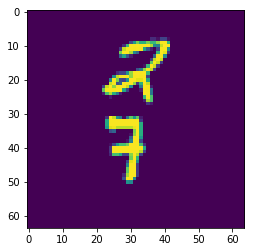

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import os.path
import numpy as np
import sys
sys.path.insert(0, './')
from utils import plot_mats
from pgpnn import ImageSplitter, PredictiveGatingPyramid

file_name = 'mnist_test_seq.npy'
url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

if not os.path.isfile(file_name):
    print("could not find dataset: download it..")
    urllib.request.urlretrieve(url, file_name)
    print("download complete")

# Moving Mnist: 10.000 sequences of length 20 showing 2 digits moving in 64x64
moving_mnist = np.load(file_name) # shape: 20,10000,64,64
moving_mnist = np.rollaxis(moving_mnist, 1) # --> 10000,20,64,64

plt.imshow(moving_mnist[0,0])
plt.show()

In [2]:
model = PredictiveGatingPyramid(depth=2, modelname='test_pgp_norm2')
model.load_network('test_pgp_norm')
#history = model.train(
#    moving_mnist,
#    epochs=500,
#    learningRate=0.0001,
#    save_results=True,
#    load_stages=True)

#plt.plot(range(0, len(history)), history)
#plt.show()

[CONSTRUCT LAYER 1]
	pre-loading weights for Layer 1
[CONSTRUCT LAYER 2]
	pre-loading weights for Layer 2


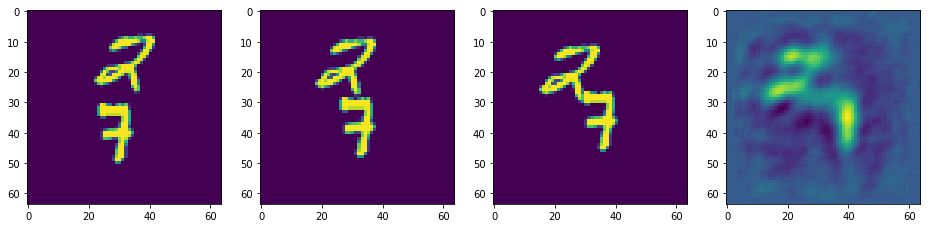

In [3]:
a = moving_mnist[0,0]
b = moving_mnist[0,1]
c = moving_mnist[0,2]
im = model.predict(a,b,c)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(141).imshow(a)
fig.add_subplot(142).imshow(b)
fig.add_subplot(143).imshow(c)
fig.add_subplot(144).imshow(im)

Calculate sigmoid cross-entropy over whole dataset:

$$
H(z,y) = - \sum_i z_i \log y_i + (1-z_i) \log (1 - y_i)
$$

(1088, 64, 64)
y: 1e-08 0.99999999
z: 1.91495284438e-09 0.99999998
Entropy: 736.723037507


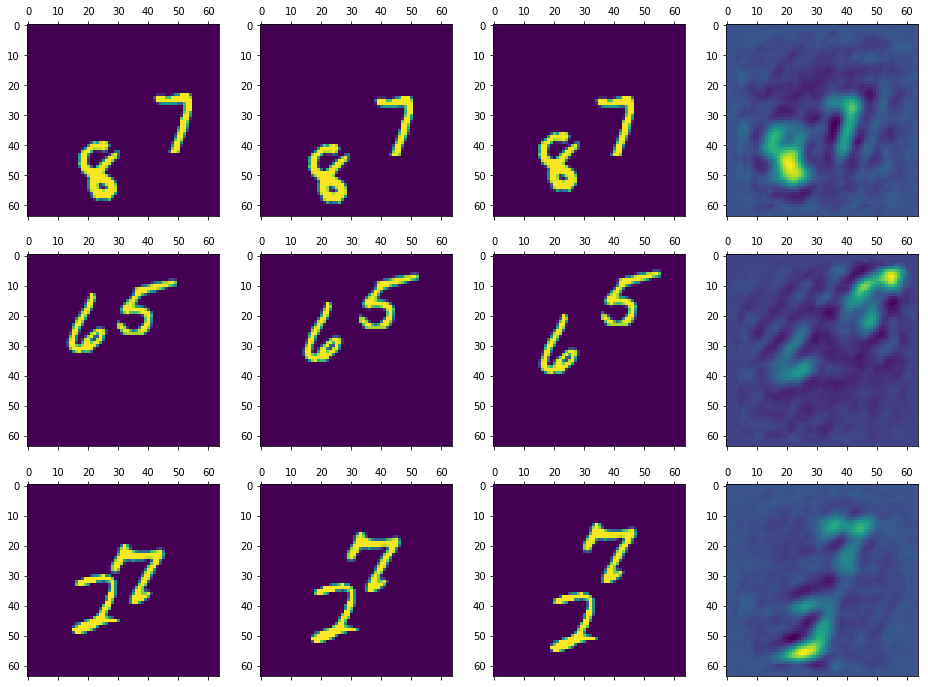

In [97]:
from time import time

def sigmoid_cross_entropy(z,y):
    num, h, w = z.shape
    z = z.reshape((num, h*w))
    y = y.reshape((num, h*w))
    
    result = z * np.log(y) + (1-z) * np.log(1-y)
    return -np.sum(result) / num
    
def pad_zero(x):
    eps = 0.00000001
    mask = (x == 0) * eps
    mask2 = (x == 1) * eps
    return (x + mask) - mask2
    

splitter = ImageSplitter(moving_mnist, ntest=0, n=4)
bs = splitter.get_batch_size()

#while splitter.is_same_batch_run():
batch = splitter.next_batch(ngram=4).reshape(bs, 4, 64, 64)
#for i in range(0, bs):
a = batch[:,0,:]
b = batch[:,1,:]
c = batch[:,2,:]
d = batch[:,3,:]
im = model.predict(a,b,c, print_debug=False)

z = pad_zero(d.astype('float32') / np.max(d))


num, h, w = im.shape
im -= np.min(im)

im = im.astype('float32')
im = pad_zero(im / np.max(im).astype('float32'))
y = im.copy().reshape((num, h * w))


#y = pad_zero(y / np.max(y, 0))

max_per_y = np.max(y, 1)

z = z.reshape((num, h * w))

z = z * np.atleast_2d(max_per_y).T

y = y.reshape((num, h, w))
z = z.reshape((num, h, w))
H = sigmoid_cross_entropy(z,y)

print("y:", np.min(y), np.max(y))
print("z:", np.min(z), np.max(z))

print("Entropy:", H)

fig = plt.figure(figsize=(16,12))

N = 3
for i in range(N):
    fig.add_subplot(N, 4, (i*4)+1).matshow(a[i*18])
    fig.add_subplot(N, 4, (i*4)+2).matshow(b[i*18])
    fig.add_subplot(N, 4, (i*4)+3).matshow(c[i*18])
    fig.add_subplot(N, 4, (i*4)+4).matshow(y[i*18])